## Урок 5. Случайный лес. Домашнее задание.

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

from sklearn.model_selection import train_test_split

In [ ]:
# Задание 1: Сформируйте посредством sklearn.make_classification датасет из 100 объектов с двумя признаками. Обучите
# случайный лес из 1, 3, 10 и 50 деревьев и визуализируйте их разделяющие гиперплоскости на графиках по подобию визуализации
# деревьев из предыдущего урока, заменив вызов функции predict на tree_vote.

# Сделайте выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от
# количества деревьев в нём.

* [Итоговая визуализация случайного леса, выводы](#randomforest)

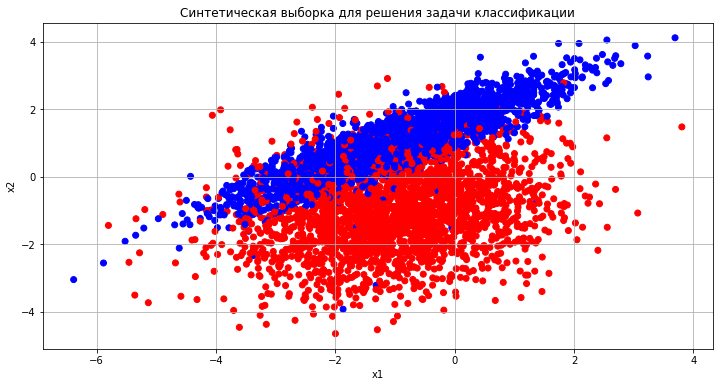

In [2]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])
plt.figure(figsize=(12,6))

X, y = datasets.make_classification(n_samples = 5000, n_features = 5, n_informative = 5, n_redundant = 0, random_state = 23,
                                    n_classes = 2, n_clusters_per_class=1)
plt.scatter(X[:,0], X[:,1], c = y, cmap = colors)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Синтетическая выборка для решения задачи классификации')
plt.grid()

In [3]:
#Генерируем выборки типа bootstrap для обучения базовых деревьев:
def get_bootstrap(data, target, n_samples):
    
    bootstrap = []
    
    for j in range(n_samples):
        data_before = np.zeros(data.shape)
        target_before = np.zeros(target.shape)
    
        for i in range(data.shape[0]):
            index = np.random.randint(0, data.shape[0])
            data_before[i] = data[index]
            target_before[i] = target[index] 
        bootstrap.append((data_before,target_before))
        
    return bootstrap 

In [4]:
#Генерируем подвыборку признаковых описаний объектов, которую мы будем использовать для построения дерева на каждом этапе 
#ветвления: таким образом, мы будем рандомизировать сам процесс построения дерева. Кол-во признаковых описаний объектов возьмем 
#равным np.sqrt(X.shape[1])
def get_subsample(data):
    length = int(np.sqrt(data.shape[1]))
    indexes = np.random.permutation(np.arange(data.shape[1]))
    return indexes[:length]

In [5]:
# Разобьем выборку на обучающую и тестовую
from sklearn import model_selection

train_X, test_X, train_y, test_y = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 1)

In [6]:
# Введем функцию подсчета точности как доли правильных ответов
def accur(y_true,y_pred):
    correct = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            correct += 1
    return (correct / float(len(y_true))) * 100.0

In [7]:
# функция формирования предсказания по выборке на одном дереве
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

# предсказание голосованием деревьев
def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [8]:
#Далее берем код из урока для построения деревьев и случайного дерева:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        
    
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

# Расчет качества
def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    #n_features = data.shape[1] - 1
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(data)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

def random_forest(data, labels, n_trees):
    forest = []
    #N  бутстрап-выборок
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

# Функция классификации отдельного объекта
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
# функция формирования предсказания по выборке на одном дереве
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

# предсказание голосованием деревьев
def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [9]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) # список массивов координатных сеток
    x = xx.reshape(-1,1)
    y = yy.reshape(-1,1)
    f = np.ones((x.shape[0],data[:, 2:].shape[1]))
    data_gr = np.concatenate((x,y,f),axis=1)
    return xx,yy , data_gr # список массивов координатных сеток

#### Визуализация деревьев и выводы: <a class='anchor' id='randomforest'>

##### Чем бОльшее количество независимых деревьев участвуют в построении случайного леса, тем точнее мы делаем предсказание на тестовой выборке: accuracy на тесте для случайного леса, построенного с участием 50 деревьев, равна 96.53. При этом гиперплоскость, разделяющая 2 класса, не выглядит переобученной. Действительно, разброс ответов базовых алгоритмов можно снизить в n раз, где n - кол-во базовых деревьев, взяв в качестве финального предсказания для каждого наблюдения мат.ожидание ответов, которые дают n базовых деревьев.

Точность предсказания на тестовой выборке с кол-вом деревьев равным 1 : 92.46666666666667
Точность предсказания на обучающей выборке с кол-вом деревьев равным 1 : 97.39999999999999
 
Точность предсказания на тестовой выборке с кол-вом деревьев равным 3 : 95.13333333333334
Точность предсказания на обучающей выборке с кол-вом деревьев равным 3 : 98.94285714285715
 
Точность предсказания на тестовой выборке с кол-вом деревьев равным 10 : 96.06666666666666
Точность предсказания на обучающей выборке с кол-вом деревьев равным 10 : 99.74285714285715
 
Точность предсказания на тестовой выборке с кол-вом деревьев равным 50 : 96.53333333333333
Точность предсказания на обучающей выборке с кол-вом деревьев равным 50 : 99.94285714285715
 


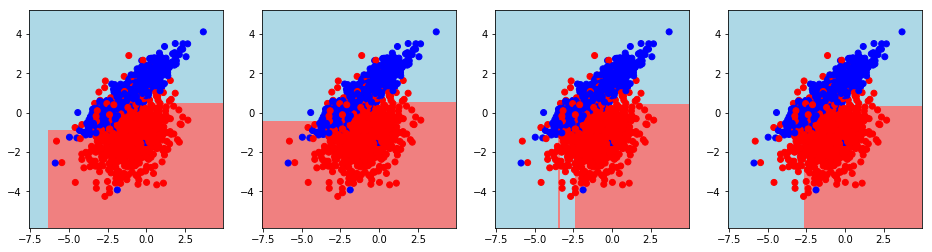

In [10]:
#Построим лес с количеством базовых деревьев [1, 3, 10 и 50], визуализируем результат на графике:
plt.figure(figsize=(16,4))

n_tress = [1, 3, 10, 50]
i = 0

for n in n_tress:
    plt.subplot(1,len(n_tress), i+1)
    xx, yy,gr = get_meshgrid(train_X)
    forest = random_forest(train_X, train_y, n)
    voted_predictions_for_test = tree_vote(forest, test_X)
    voted_predictions_for_train = tree_vote(forest, train_X)
    mesh_predictions = np.array(tree_vote(forest, gr)).reshape(xx.shape)

    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_X[:,0], test_X[:,1], c = test_y, cmap = colors)
    print(f'Точность предсказания на тестовой выборке с кол-вом деревьев равным {n} : {accur(test_y,voted_predictions_for_test)}')
    print(f'Точность предсказания на обучающей выборке с кол-вом деревьев равным {n} : {accur(train_y,voted_predictions_for_train)}')
    print(' ')  
    i += 1

In [24]:
# Задание 2: Замените в реализованном алгоритме проверку, используя отложенную выборку на Out-of-Bag.

#Перепишем функцию get_bootstrap, сформируем вместе с бутстрапированной выборкой список индексов, которые не попали в бутстрап 
#выборку
global bootstrap_for_test
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    indexes = {}
    bootstrap_for_test = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            #записываем индексы строк, попавшие в бутстрапированную выборку n-го дерева, в словарь indexes (ключ - номер дер-ва)
            if i not in indexes:
                indexes[i] = [sample_index]
            else:
                indexes[i].append(sample_index)
            #-----------------------------------------------------------------------------------------------------------------   
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
        #создаем выборку для теста--------------------------------------------------------------------------------------------
        data_for_test = np.zeros((len(set(np.arange(X.shape[0])) -  set(indexes[0])),data.shape[1]))
        labels_for_test = np.zeros((len(set(np.arange(X.shape[0])) -  set(indexes[0])),))
        
        l = 0
        for k in set(np.arange(X.shape[0])) -  set(indexes[0]):
            data_for_test[l] = data[k, :]
            labels_for_test[l] = labels[k]
            l= l + 1
        bootstrap_for_test.append((data_for_test, labels_for_test))
        
    return bootstrap, bootstrap_for_test

* [Out-of-Bag, выводы](#outofbag)

In [25]:
#Далее берем код из урока для построения деревьев и случайного дерева:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        
    
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

# Расчет качества
def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    #n_features = data.shape[1] - 1
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(data)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

def random_forest(data, labels, n_trees):
    forest = []
    forest_for_test = []
    #N  бутстрап-выборок
    bootstrap, bootstrap_for_test = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))  
        
    return (forest, bootstrap_for_test)

# Функция классификации отдельного объекта
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
# функция формирования предсказания по выборке на одном дереве
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

# предсказание голосованием деревьев
def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

#### Out-of-bag: <a class='anchor' id='outofbag'>

##### Случайные леса, построенные на основе бутстрапированных выборок для базовых деревьев, обладают интересным свойством: на 37% наблюдений деревья не обучались, значит мы можем их успешно использовать для замера точности построенных алгоритмов без отложенной выборки и кросс-валидации.

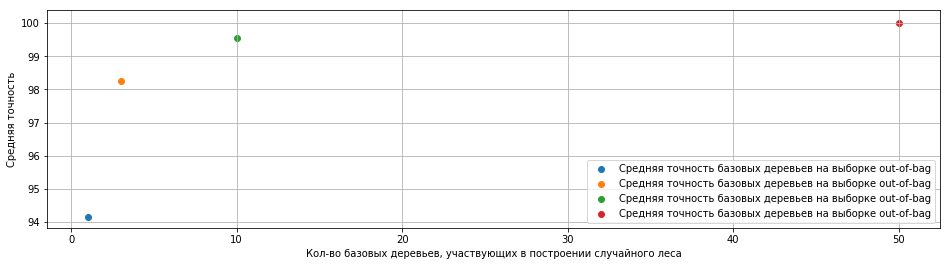

In [26]:
n_tress = [1, 3, 10, 50]
i = 0
voted_for_test = {}
accuracy_for_test = {}

for n in n_tress:
    forest, bootstrap_for_test = random_forest(X, y, n)
    voted_predictions_for_train = tree_vote(forest, X)
    for sample in bootstrap_for_test:
        if n not in voted_for_test:
            voted_for_test[n] = [tree_vote(forest, sample[0])]
            accuracy_for_test[n] = [accur(sample[1], tree_vote(forest, sample[0]))]
        voted_for_test[n].append(tree_vote(forest, sample[0]))
        accuracy_for_test[n].append(accur(sample[1], tree_vote(forest, sample[0])))
        
plt.figure(figsize=(16,4))
for tree in accuracy_for_test.keys():
    plt.scatter(tree, np.mean(accuracy_for_test[tree]), label = 'Средняя точность базовых деревьев на выборке out-of-bag')
    plt.xlabel('Кол-во базовых деревьев, участвующих в построении случайного леса')
    plt.ylabel('Средняя точность')
    plt.legend()
    plt.grid(True)  

In [ ]:
# Задание 3 (На повторение) Перепишите функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия
# использовалась энтропия Шеннона. Переименуйте функцию в calc_entropy.

In [27]:
# Расчет энтропии Шеннона:

def calc_entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p*np.log2(p)
        
    return impurity, classes